In [1]:
import pandas as pd
import numpy as np
from tools import files
import os.path as op
import matplotlib.pylab as plt
from matplotlib import gridspec
from scipy.stats import sem
import seaborn as sns
from pathlib import Path

In [2]:
path = "/cubric/data/c1557187/meg_pipeline_action_mismatch/beh_data"

In [3]:
times = np.linspace(0.0, 1.5, num=375)

In [4]:
files = [filename for filename in Path('/cubric/scratch/c1557187/act_mis/BEH').glob('**/*.pkl')]
files.sort()
data = []
for file in files:
    d = pd.read_pickle(file)
    d.exp_type = str(file).split("/")[-1].split("_")[0][-1]
    data.append(d)
data = pd.concat(data)
data["RT"] = None
data.RT = data.action_onset.apply(lambda x: times[x])
data.obs_dir_mod = pd.Categorical(data.obs_dir_mod)

In [5]:
# data["avg_speed"] = data.degs.apply(lambda x: np.abs(x).sum()/1.5)
data["avg_speed"] = data.degs.apply(lambda x: np.abs(x.sum())/1.5)

In [9]:
print(list(data))

['ID', 'ITI_dur', 'ITI_onset', 'age', 'blink_dur', 'blink_onset', 'exp_type', 'fix_dur', 'fix_onset', 'gender', 'movement_dir', 'obs_dir_mod', 'obs_dur', 'obs_onset', 'rot_dur', 'rot_onset', 'trial', 'trig_obs', 'trig_rot', 'x', 'y', 'angle', 'radius', 'degs', 'action_onset', 'RT', 'avg_speed']


### MOVEMENT HEATMAP

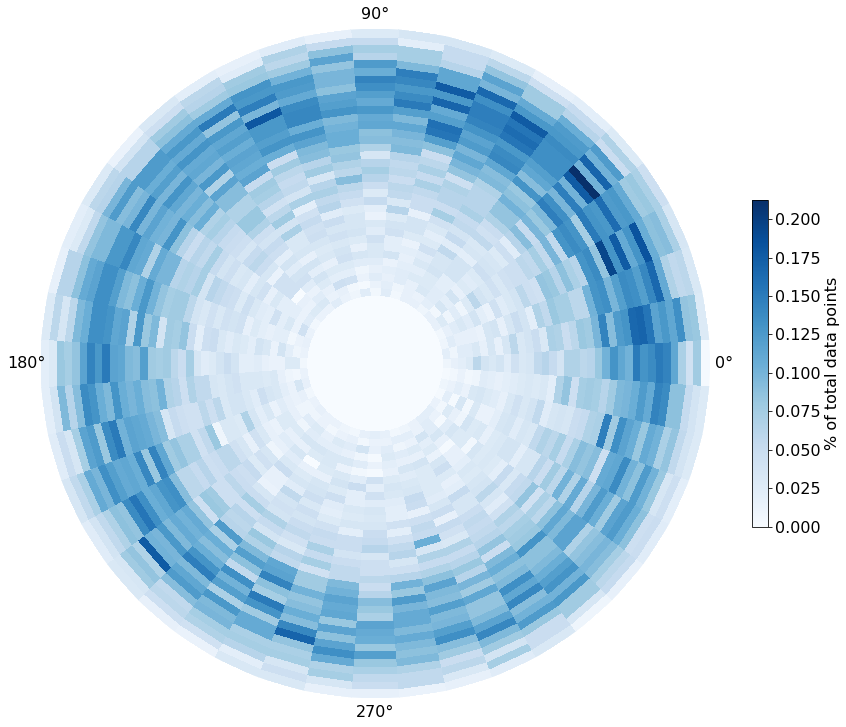

In [140]:
font = {
    "family": "sans",
    "size": 16,
    "weight": "normal"
}

plt.rc("font", **font)

bins = 45

def norm_rad(x):
    radius = x
    if np.max(x) > 1:
        radius = (x - np.min(x)) / (np.max(x) - np.min(x))
    return radius

rad = np.hstack(list(data.radius.apply(norm_rad)))
theta = np.hstack(list(data.angle))
weights = np.ones(rad.shape)
weights_bool = rad < 0.2
weights[weights_bool] = 0.0
rad_range = [np.deg2rad(0), np.deg2rad(360)]
H, xedges, yedges = np.histogram2d(
    rad, 
    theta, 
    weights=weights, 
    bins=[bins,bins], 
    range=[[0,1],rad_range], 
    density=False)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection="polar")
ax.set_frame_on(False)
theta, rad = np.meshgrid(np.deg2rad(np.linspace(-4,356, num=bins)), np.linspace(0,1, num=bins))
pcm = ax.pcolormesh(theta, rad, H/H.sum()*100, cmap="Blues")
cbr = fig.colorbar(pcm, ax=ax, extend="neither", drawedges=False, shrink=0.4)
cbr.set_label("% of total data points")
ax.set_facecolor("None")
# ax.set_rticks([0.2, 1])
ax.set_rticks([])
ax.set_thetagrids(angles=[0, 90, 180, 270])

plt.savefig(op.join(path, "heatmap.png"), dpi=300, bbox_inches="tight")


### DIRECTION OF THE MOVEMENT

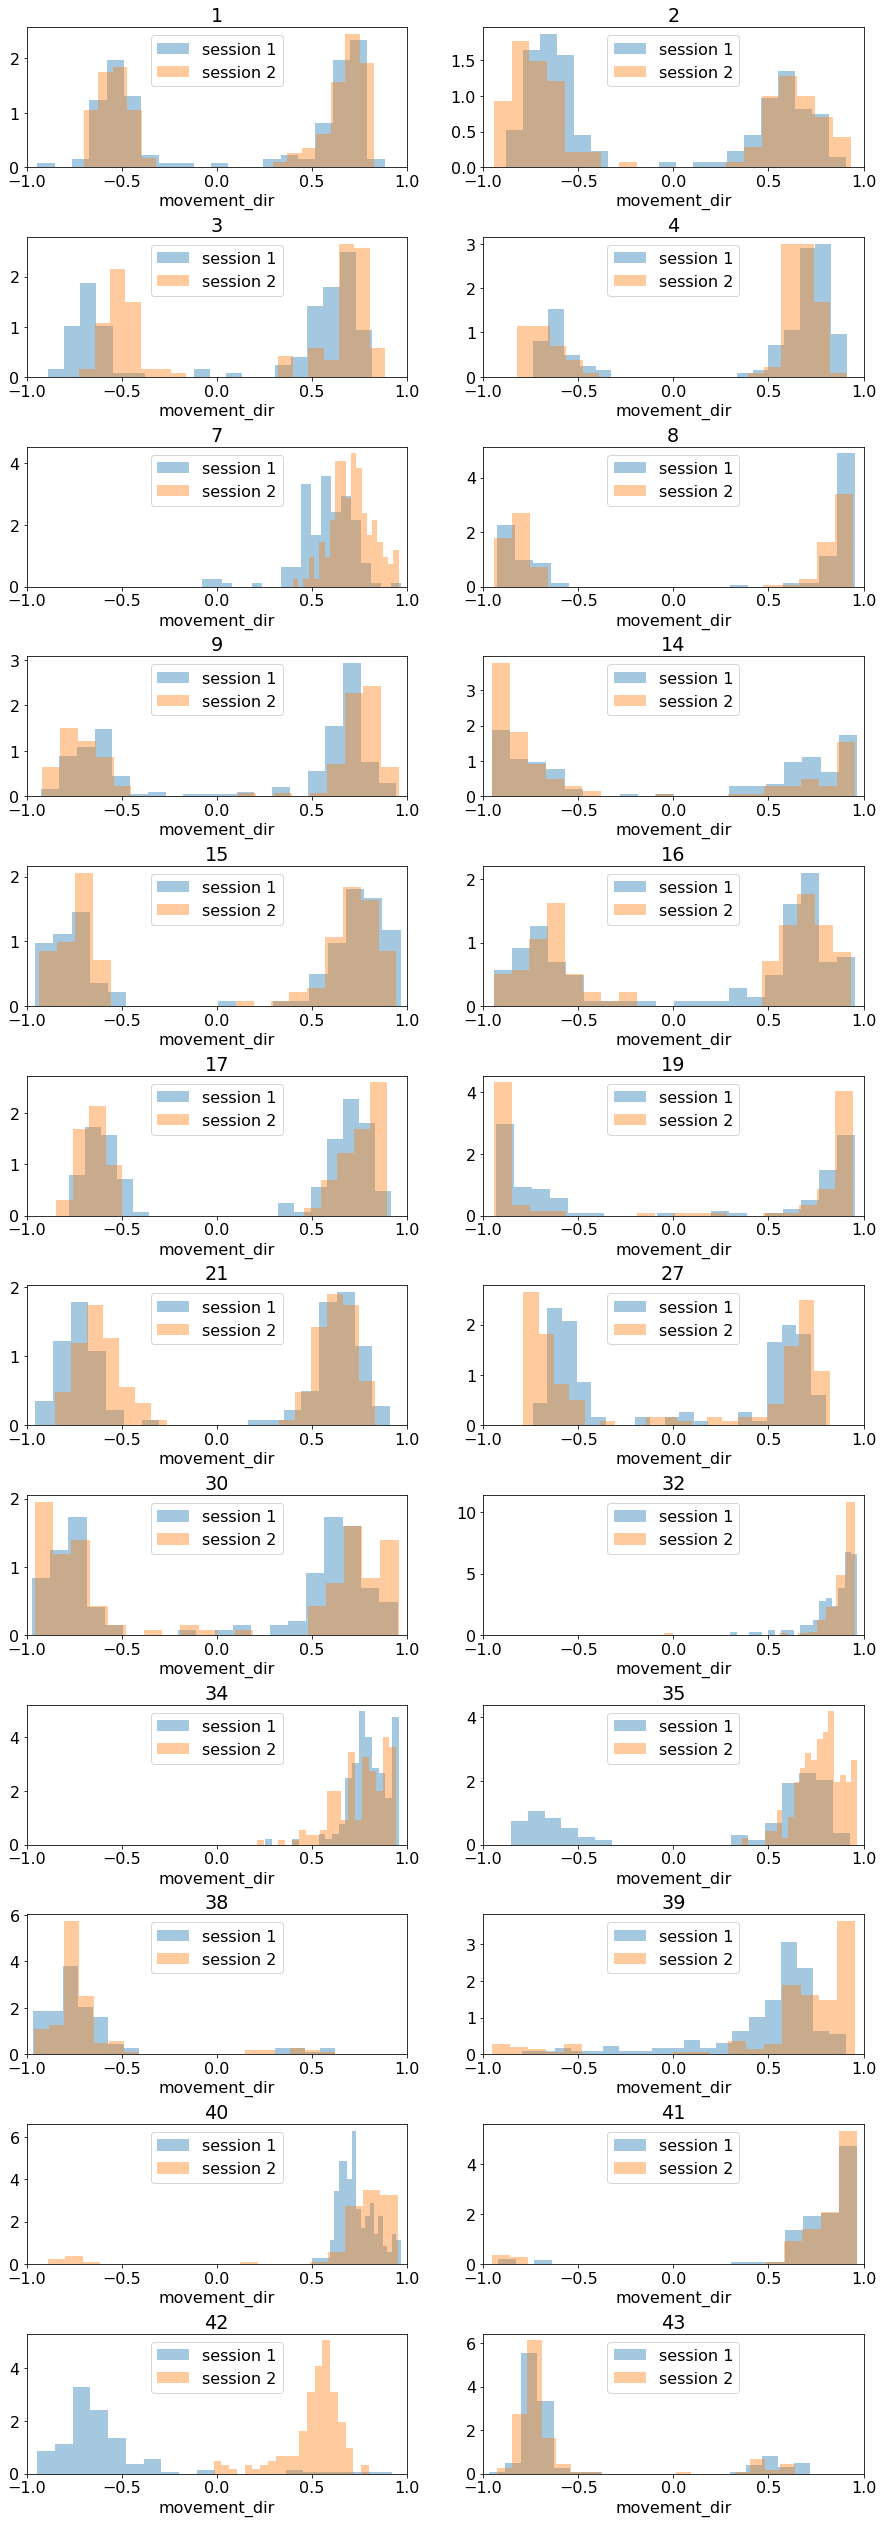

In [166]:
subj_am = len(data.ID.unique())
fig = plt.figure(figsize=(15, 45))
columns = 2
rows = subj_am / columns
gs = fig.add_gridspec(int(rows), columns, hspace=0.5)

for ind, pp in enumerate(data.ID.unique()):
    ax = fig.add_subplot(gs[ind], label=str(pp))
    sns.distplot(data.loc[(data.ID == pp) & (data.exp_type == "1")].movement_dir, ax=ax, hist=True, kde=False, norm_hist=True, bins=20, label="session 1")
    sns.distplot(data.loc[(data.ID == pp) & (data.exp_type == "2")].movement_dir, ax=ax, hist=True, kde=False, norm_hist=True, bins=20, label="session 2")
    ax.legend(loc=9)
    plt.xlim((-1, 1))
    plt.title(str(pp))

plt.savefig(op.join(path, "mov_dir_pp.png"), dpi=300, bbox_inches="tight")

### MOVEMENT ONSET

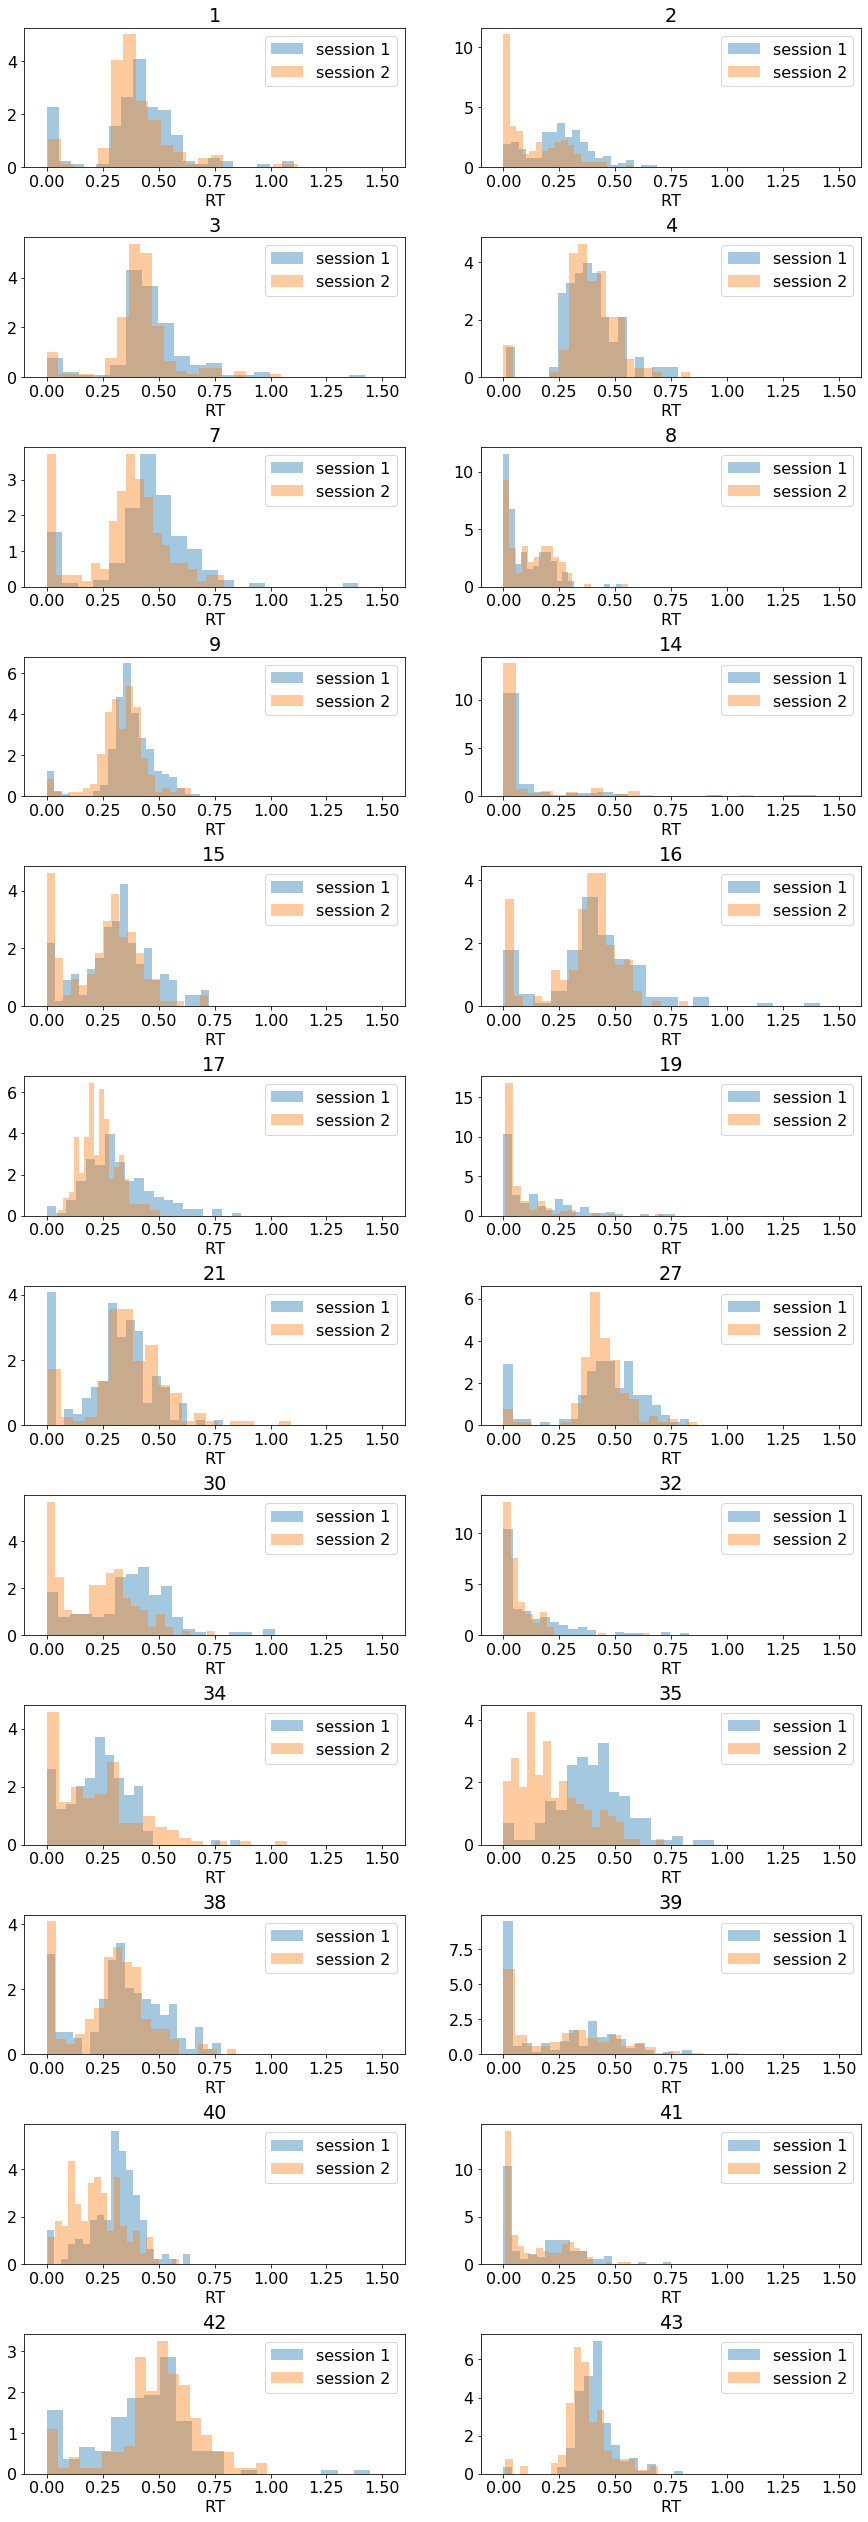

In [164]:
subj_am = len(data.ID.unique())
fig = plt.figure(figsize=(15, 45))
columns = 2
rows = subj_am / columns
gs = fig.add_gridspec(int(rows), columns, hspace=0.5)

for ind, pp in enumerate(data.ID.unique()):
    ax = fig.add_subplot(gs[ind], label=str(pp))
    sns.distplot(data.loc[(data.ID == pp) & (data.exp_type == "1")].RT, ax=ax, hist=True, kde=False, norm_hist=True, bins=20, label="session 1")
    sns.distplot(data.loc[(data.ID == pp) & (data.exp_type == "2")].RT, ax=ax, hist=True, kde=False, norm_hist=True, bins=20, label="session 2")
    ax.legend(loc=1)
    plt.xlim((-0.1, 1.6))
    plt.title(str(pp))

plt.savefig(op.join(path, "mov_ons_pp.png"), dpi=300, bbox_inches="tight")

### AVERAGE SPEED

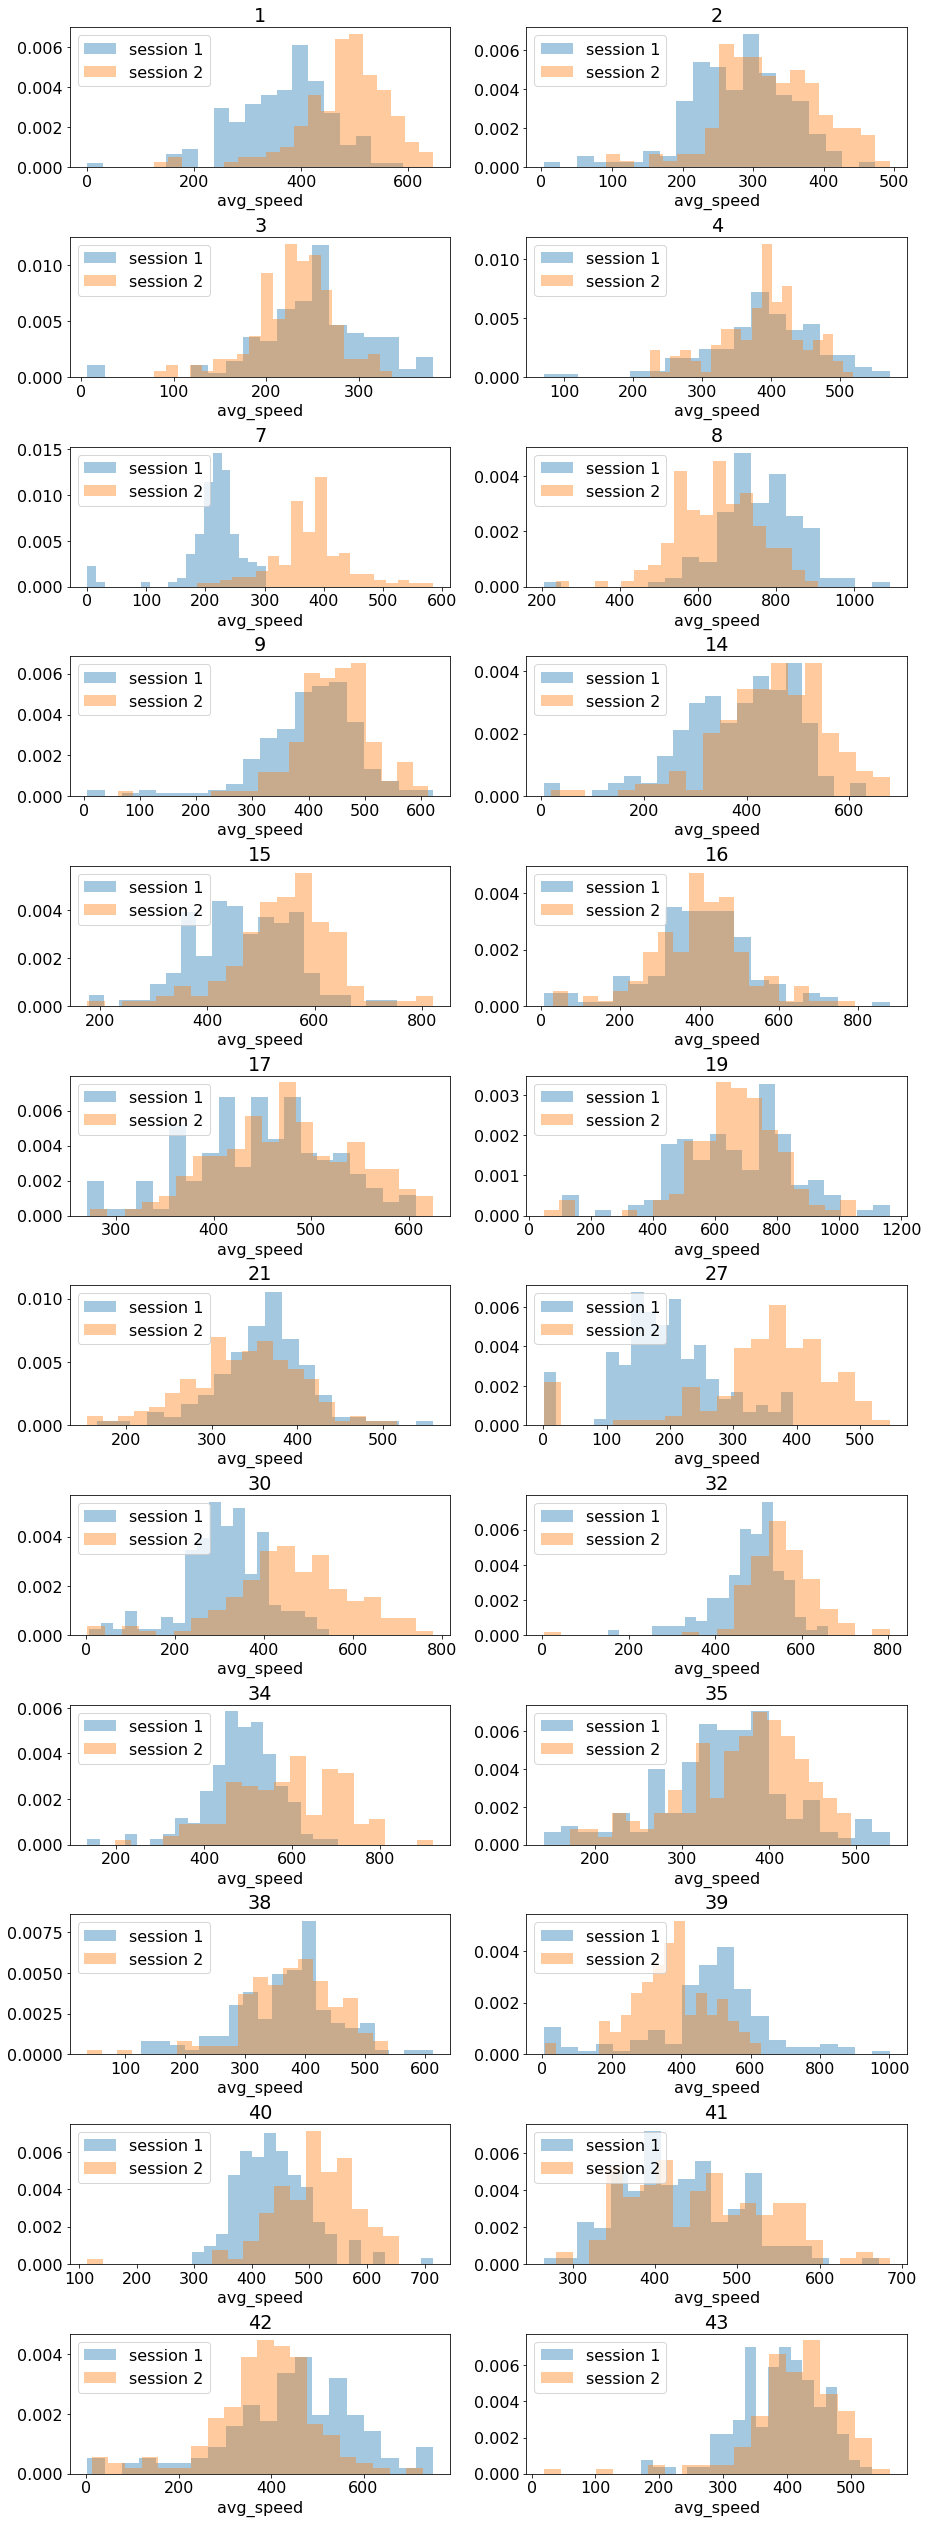

In [177]:
subj_am = len(data.ID.unique())
fig = plt.figure(figsize=(15, 45))
columns = 2
rows = subj_am / columns
gs = fig.add_gridspec(int(rows), columns, hspace=0.5)

for ind, pp in enumerate(data.ID.unique()):
    ax = fig.add_subplot(gs[ind], label=str(pp))
    sns.distplot(data.loc[(data.ID == pp) & (data.exp_type == "1")].avg_speed, ax=ax, hist=True, kde=False, norm_hist=True, bins=20, label="session 1")
    sns.distplot(data.loc[(data.ID == pp) & (data.exp_type == "2")].avg_speed, ax=ax, hist=True, kde=False, norm_hist=True, bins=20, label="session 2")
    ax.legend(loc=2)
    plt.title(str(pp))

plt.savefig(op.join(path, "mov_avg_spd_sumdiff_pp.png"), dpi=300, bbox_inches="tight")

In [178]:
print("M", np.deg2rad(data.avg_speed.mean()), "SD", np.deg2rad(data.avg_speed.std()))

M 7.396599090334382 SD 2.599658494338727


In [15]:
data = data.loc[(data.obs_dir_mod != 0)]

In [16]:
tosave = data.sort_values(["ID", "exp_type", "trial"])

In [17]:
tosave.to_pickle("beh_data/all_trials.pkl")